In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import xgboost as xgb

In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut
from sklearn import metrics

In [4]:
data = pd.read_csv('Train_updated.csv')
data_test = pd.read_csv('Test.csv')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5,6,7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
data['class'] = 0
data.loc[(data['caseLevelResultCode'] == 'PARTIAL_RESULT'), 'class'] = 1
data.loc[(data['caseLevelResultCode'] == 'HIGH_PROB_POSITIVE_RESULT'), 'class'] = 2

## Evaluate classifier

In [7]:
data_train = data[['maternalAge', 'maternalWeight', 'gestationalAge', 'fetalFraction', 'class']]

In [8]:
x = data_train[['maternalAge', 'maternalWeight', 'gestationalAge', 'fetalFraction']].values
y = data_train['class'].values

x_weights = np.ones(len(x))
x_weights[y == 0] = len(y[y==2])/len(y[y==0])
x_weights[y == 1] = len(y[y==2])/len(y[y==1])

y_preds = []
y_tests = []
kf = StratifiedKFold(n_splits=5, shuffle=True)
kf.get_n_splits(x,y)
for train_idx, test_idx in tqdm(kf.split(x,y)):
    x_train = x[train_idx]
    xw_train = x_weights[train_idx]
    y_train = y[train_idx]
    x_test = x[test_idx]
    y_test = y[test_idx]
    
    model = xgb.XGBClassifier(n_estimators=1000, learning_rate=1.0, max_depth=3, n_jobs=3).fit(x_train, y_train, sample_weight=xw_train)
    y_tests.extend(y_test)
    y_preds.extend(model.predict_proba(x_test))

y_tests_cls = np.array(y_tests).astype(float)
y_preds_cls = np.array(y_preds)

0it [00:00, ?it/s]/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:46:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


1it [02:59, 179.93s/it]

[09:49:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2it [05:51, 177.54s/it]

[09:52:00] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


3it [08:48, 177.31s/it]

[09:54:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


4it [11:55, 180.21s/it]

[09:58:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


5it [14:58, 179.78s/it]


Accuracy: 0.9937123767943375, C.E. Loss: 0.031875524177893626
Confusion Matrix:
[[595467    163    656]
 [    69   1151   1251]
 [   152   1511   4260]]
Sensitivity (partial): 0.4658033184945366
Sensitivity (positive): 0.7192301198716866


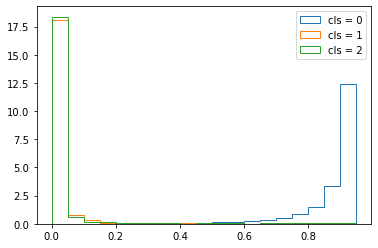

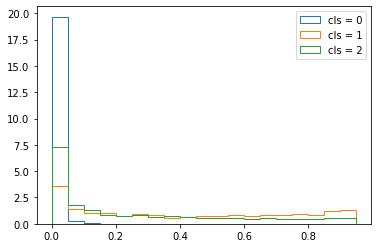

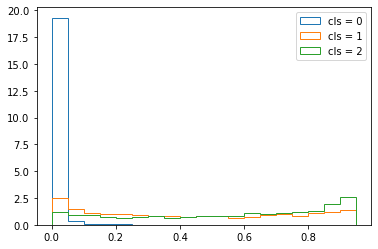

In [9]:
celoss_cls = metrics.log_loss(y_tests_cls, y_preds_cls)
accuracy_cls = metrics.accuracy_score(y_tests_cls, y_preds_cls.argmax(axis=1))
print('Accuracy: '+str(accuracy_cls)+', C.E. Loss: '+str(celoss_cls))
cm = metrics.confusion_matrix(y_tests_cls, y_preds_cls.argmax(axis=1))
print('Confusion Matrix:')
print(cm)
print('Sensitivity (partial): '+str(cm[1][1]/sum(cm[1])))
print('Sensitivity (positive): '+str(cm[2][2]/sum(cm[2])))

plt.figure()

plt.hist(y_preds_cls.T[0][y_tests_cls == 0], bins=np.arange(0,1,0.05), density=True, histtype='step', label='cls = 0');
plt.hist(y_preds_cls.T[0][y_tests_cls == 1], bins=np.arange(0,1,0.05), density=True, histtype='step', label='cls = 1');
plt.hist(y_preds_cls.T[0][y_tests_cls == 2], bins=np.arange(0,1,0.05), density=True, histtype='step', label='cls = 2');

plt.legend(loc='upper right');

plt.figure()

plt.hist(y_preds_cls.T[1][y_tests_cls == 0], bins=np.arange(0,1,0.05), density=True, histtype='step', label='cls = 0');
plt.hist(y_preds_cls.T[1][y_tests_cls == 1], bins=np.arange(0,1,0.05), density=True, histtype='step', label='cls = 1');
plt.hist(y_preds_cls.T[1][y_tests_cls == 2], bins=np.arange(0,1,0.05), density=True, histtype='step', label='cls = 2');

plt.legend(loc='upper right');

plt.figure()

plt.hist(y_preds_cls.T[2][y_tests_cls == 0], bins=np.arange(0,1,0.05), density=True, histtype='step', label='cls = 0');
plt.hist(y_preds_cls.T[2][y_tests_cls == 1], bins=np.arange(0,1,0.05), density=True, histtype='step', label='cls = 1');
plt.hist(y_preds_cls.T[2][y_tests_cls == 2], bins=np.arange(0,1,0.05), density=True, histtype='step', label='cls = 2');

plt.legend(loc='upper right');

## Make submission

In [11]:
x = data_train[['maternalAge', 'maternalWeight', 'gestationalAge', 'fetalFraction']].values
y = data_train['class'].values

x_weights = np.ones(len(x))
x_weights[y == 0] = len(y[y==2])/len(y[y==0])
x_weights[y == 1] = len(y[y==2])/len(y[y==1])

model = xgb.XGBClassifier(n_estimators=1000, learning_rate=1.0, max_depth=3, n_jobs=3).fit(x, y, sample_weight=x_weights)

x_test = data_test[['maternalAge', 'maternalWeight', 'gestationalAge', 'fetalFraction']].values
y_tst_preds = model.predict_proba(x_test)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:11:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [97]:
submission = data_test[['RecordID']]
submission['Negative'] = y_tst_preds.T[0]
submission['Partial'] = y_tst_preds.T[1]
submission['Positive'] = y_tst_preds.T[2]

<ipython-input-97-d77a94ec31b2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Negative'] = y_tst_preds.T[0]
<ipython-input-97-d77a94ec31b2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Partial'] = y_tst_preds.T[1]
<ipython-input-97-d77a94ec31b2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [115]:
submission.to_csv('Abhijeet_Kate_Yuhang_Submission-2.csv')